# Data Inspection

This notebook aims at having a first look at the data, trying to understand the data structure, and identifying potential biases in the provided dataset. 

In [2]:
# Libraries imported in alphabetical order

%matplotlib notebook

from pathlib import Path # Loop over folder structures 
from PIL import Image # Load image data 
from skimage.measure import label # Find clusters in the label data
from tqdm.notebook import tqdm # Access to a progressbar

# Import standard data science libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# First, rename mask folder to remove spaces
!mv -f data/mask\ binary/ data/mask_binary/

mv: cannot stat 'data/mask binary/': No such file or directory


In [4]:
# Set root paths of provided image data 
root_path = Path("data/tissue_images/")


### Helper function to handle file paths of image and label data

Dealing with multiple path variables can be confusing. Therefore, I generate a help function to convert img paths in label paths

In [5]:
def change_img_to_label_path(path, fol_pre = 'tissue_images', fol_post = 'mask_binary', suf_pre = 'tif', suf_post = 'png'):
    """
    Helper function to rename img paths to match label paths
    """
    
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index(fol_pre)] = fol_post  # Replace tissue_images with mask_binary
    
    # Get Filename of Path by string splitting the last entry 
    filename = parts[-1].split(".")
    # Replace Filename Suffix
    filename[filename.index(suf_pre)] = suf_post
    
    #Put Together all parts to create the list new_path, pointing to the label directory
    new_path = parts[:-1] + [str(filename[0]) + "." + str(filename[1])]

    return Path(*new_path)  # Combine list back into a Path object


For future use, this function will be stored in functions.py 

### Load and display an exemplary dataset 

Generate and check img and label path variables

In [6]:
sample_path = list(root_path.glob("Human_*"))[0]  # Choose the first entry as an exemplary sample 
sample_path_label = change_img_to_label_path(sample_path) # Convert path to label path

print(sample_path)
print(sample_path_label)

data/tissue_images/Human_AdrenalGland_01.tif
data/mask_binary/Human_AdrenalGland_01.png


Look at img and label dimensions

In [7]:
# Load the image files with PIL and convert the to numpy arrays
img = np.asarray(Image.open(sample_path))
mask = np.asarray(Image.open(sample_path_label))

print('Image Size = {} x {}'.format(img.shape[0], img.shape[1]))
print('Label Size = {} x {}'.format(mask.shape[0], mask.shape[1]))

Image Size = 512 x 512
Label Size = 512 x 512


Display the loaded image data, overlayed with nuclei labels

<IPython.core.display.Javascript object>


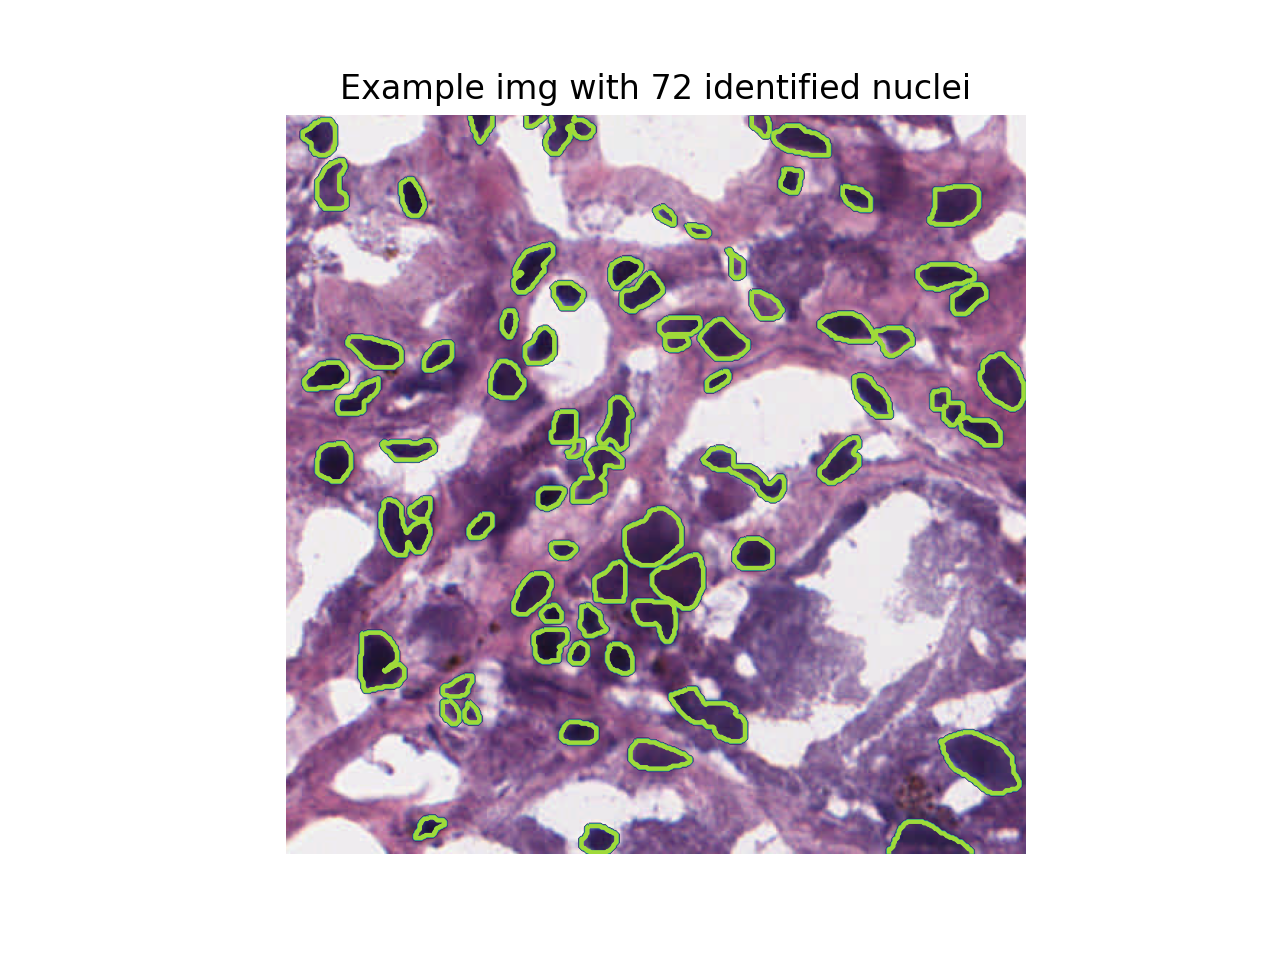

(-0.5, 511.5, 511.5, -0.5)

In [10]:
# Extract individual masks using 'labels' from scikit-image
# I chose connectivity = 1 to count only directly connected masks
labeled_masks = label(mask, connectivity=1, background = 0)

# scikit image label marks every nonzero cluster with a counting number. 
# Therefore, to identify the number of nuclei, the amount of unique elements in 'labeled_masks' needs to be counted   

# Generate Matplotlib Figure 
plt.figure()
plt.title('Example img with {} identified nuclei'.format(len(np.unique(labeled_masks[labeled_masks > 0]))))
plt.imshow(img)
plt.contour(mask)
plt.axis('off')

Loop over all images, check if dimensions match, and check the tissue types   

In [19]:
all_files = list(root_path.glob("*tif"))  # Get paths to all subjects
print('Total {} images to check'.format(len(all_files)))

Total 28 images to check


Loop over all subjects and save image metadata in pandas dataframe

In [20]:
df = pd.DataFrame(columns=['Path', 
                           'Tissue', 
                           'Img Width', 
                           'Img Height', 
                           'Mask Width', 
                           'Mask Height', 
                           'Size Conflict',
                           'Img Max Val'])

# Loop over all img files
for counter, path_to_img in enumerate(tqdm(all_files)):

    # Get mask path from img path
    path_to_label = change_img_to_label_path(path_to_img)
    
    # Load the data
    img = np.asarray(Image.open(path_to_img))
    mask = np.asarray(Image.open(path_to_label))
    
    # Extract width and heigth of img and label
    ImgWidth =  img.shape[0]
    ImgHeight =  img.shape[1]
    MaskWidth =  mask.shape[0]
    MaskHeight = mask.shape[1]
    
    # Check if img and label sizes match
    if img.shape[:2] == mask.shape:
        SizeConflict = False
    else:
        SizeConflict = True
        
    # Check the filename to identify tissue type
    filename = path_to_img.name
    tissue_type = filename.split('_')[1]
    
    # Put all subject specific metadata in dict structure and append to dataframe
    df2 = {'Path':path_to_label, 
           'Tissue':tissue_type, 
           'Img Width':ImgWidth, 
           'Img Height':ImgHeight, 
           'Mask Width':MaskWidth, 
           'Mask Height':MaskHeight,
           'Size Conflict':SizeConflict,
           'Img Max Val':img.max()}

    df = df.append(df2, ignore_index = True)




  0%|          | 0/28 [00:00<?, ?it/s]

Check dataframe structure

In [43]:
df

,Path,Tissue,Img Width,Img Height,Mask Width,Mask Height,Size Conflict,Img Max Val
0,data/mask_binary/Human_AdrenalGland_01.png,AdrenalGland,512,512,512,512,False,255
1,data/mask_binary/Human_Mediastinum_03.png,Mediastinum,512,512,512,512,False,255
2,data/mask_binary/Human_Mediastinum_02.png,Mediastinum,512,512,512,512,False,255
3,data/mask_binary/Human_ThyroidGland_03.png,ThyroidGland,512,512,512,512,False,255
4,data/mask_binary/Human_LymphNodes_01.png,LymphNodes,512,512,512,512,False,255
5,data/mask_binary/Human_Thymus_02.png,Thymus,512,512,512,512,False,255
6,data/mask_binary/Human_Thymus_03.png,Thymus,512,512,512,512,False,255
7,data/mask_binary/Human_Skin_03.png,Skin,512,512,512,512,False,255
8,data/mask_binary/Human_Pancreas_01.png,Pancreas,512,512,512,512,False,255
9,data/mask_binary/Human_Skin_02.png,Skin,512,512,512,512,False,255


No size conflicts identified!

Finally, check and count the provided tissue types. This way, we can identify potential sampling biases that would need to be counteracted by random weighted sampling during the training. 

In [21]:
print("Tissue Types: {}".format(df['Tissue'].unique()))

Tissue Types: ['AdrenalGland' 'Mediastinum' 'ThyroidGland' 'LymphNodes' 'Thymus' 'Skin'
 'Pancreas' 'Testes' 'Pleura' 'Larynx']


In [22]:
df['Tissue'].value_counts()

Pleura          3
Pancreas        3
Skin            3
Thymus          3
AdrenalGland    3
Larynx          3
Testes          3
Mediastinum     3
ThyroidGland    2
LymphNodes      2
Name: Tissue, dtype: int64

It seems that there is no strong oversampling of one specific tissue type. Hence, we will not use weighted data loaders. 

In [51]:
print(img.shape)
img.mean(axis = (0,1))
img.std(axis = (0,1))

(512, 512, 3)


array([50.20419395, 43.08574425, 37.89285443])